In [26]:
from utils import run_sim_collect_all_data, construct, plot_sim, sweep_with_testing, sample_action, get_observation, plot_testing, plot_b_matrices
import pymdp 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
cmap0 = LinearSegmentedColormap.from_list("", ["white", "black"])
import seaborn as sns

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

observation_CC = [0]
observation_CD = [1]
observation_DC = [2]
observation_DD = [3]
BC = np.array([[0.5,0.5,0.5,0.5],[0.5,0.5,0.5,0.5],[0,0,0,0],[0,0,0,0]])
BD = np.array([[0,0,0,0],[0,0,0,0],[0.5,0.5,0.5,0.5],[0.5,0.5,0.5,0.5]])
sD=np.array([0,0,0,1])
sC = np.array([1,0,0,0])


In [4]:

def single_agent_run(observation, agent):
    agent.D = np.array([0.25,0.25,0.25,0.25])
    qs = agent.infer_states(observation)

    qp, efe = agent.infer_policies()

    action = sample_action(agent)
    agent.action = action

    return action, qs, qp

Determinsitic agents with the same learning rate - Data from real simulation

In [5]:

def run_pavlov_agent(lr = 0.3, T = 2000):
    """ This code collects data for a dual agent run where both agents are determinnistic and have the same learning rate
    The resulting agent will have learned the Pavlov strategy"""

    agent_pavlov, agent_2, D = construct(lr_pB = lr, lr_pB_2=lr, factors_to_learn="all")
    #training
    actions_over_time, B1_over_time, qpB_over_time, q_pi_over_time, q_s_over_time, agent = run_sim_collect_all_data(agent_pavlov, agent_2, observation_1 = [1], observation_2 = [1],D=D,T=T)
    return actions_over_time, B1_over_time, qpB_over_time, q_pi_over_time, q_s_over_time, agent

In [59]:
def learning_rate_sweep(lr_0 = 0, lr_1 = 1, num_lrs = 50, T = 50):
    """This function collects the actions over time for Pavlov agents configured given a series of learning rates
    This function is slow!"""
    all_actions_over_time = []

    for lr in np.linspace(lr_0,lr_1,num_lrs):
        actions_over_time, _, _, _, _, _ = run_pavlov_agent(lr, T)
        all_actions_over_time.append(actions_over_time)

    return all_actions_over_time


In [63]:
def tau_1_by_lr(actions_over_time_and_lr):
    """This creates data to plot tau1 (the duration of the defection period, before oscillation begins) for deterministic pavlov agents for different learning rates"""
    tau_1_over_lr = []
    end = len(actions_over_time_and_lr) - 2
    for a in actions_over_time_and_lr:
        current = a[:,0]
        for i, action in enumerate(current[:-1]):
            if action == 1:
                if current[i+1] == 0 and current[i+2] == 1:
                    tau_1_over_lr.append(i)
                    break
            if i == end:
                tau_1_over_lr.append(-1)
                break
    masked_array = np.ma.masked_where(tau_1_over_lr == -1, tau_1_over_lr)
    return masked_array


In [70]:
def tau_2_by_lr(actions_over_time_and_lr = None):
    """This creates data to plot tau1 (the duration of the defection period, before oscillation begins) for deterministic pavlov agents for different learning rates"""
    tau_2_over_lr = []
    end = len(actions_over_time_and_lr) - 4
    if not actions_over_time_and_lr:
        actions_over_time_and_lr = learning_rate_sweep()
    for a in actions_over_time_and_lr:
        current = a[:,0]
        for i, action in enumerate(current[:-1]):
            if action == 1:
                if current[i+1] == 0 and current[i+2] == 0 and current[i+3] == 0:
                    tau_2_over_lr.append(i)
                    break
            if i == end:
                tau_2_over_lr.append(-1)
                break
    masked_array = np.ma.masked_where(tau_2_over_lr == -1, tau_2_over_lr)
    return masked_array


In [23]:
def plot_dirichlet_parameters(qpB_over_time, num_steps = 99):
    """ Plots the simulated parameters of the transition dirichlet prior over time"""
    fig = plt.figure(figsize = (8,6))
    qBC_C = [qpB_over_time[i][0,0,0] for i in range(num_steps)]
    qBD_D = [qpB_over_time[i][-1,-1,1] for i in range(num_steps)]
    qBC_D = [qpB_over_time[i][3,0,1] for i in range(num_steps)]
    qBD_C = [qpB_over_time[i][0,3,0] for i in range(num_steps)]
    plt.plot(qBC_C, label = r"$qB^{\mathbf{CC}}(u^{\mathbf{C}})$")
    plt.plot(qBD_D, label = r"$qB^{\mathbf{DD}}(u^{\mathbf{D}})$")
    plt.plot(qBC_D, label = r"$qB^{\mathbf{CC}}(u^{\mathbf{D}})$")
    plt.plot(qBD_C, label = r"$qB^{\mathbf{DD}}(u^{\mathbf{C}})$")
    plt.title("Simulated QB over time")
    plt.xlabel("Number of trials")
    plt.ylabel("Parameters of Dirichlet Prior")
    plt.legend()
    return qBC_C, qBD_D, qBC_D, qBD_C
    

Data from derived analytic equations

In [9]:

def approximate_tau1_over_lr(lr_0 = 0, lr_1 = 1, num_lrs = 50):
    """This function uses the equation we derived approximating tau1 for different learning rates
    and returns a list of tau1 for a given set of lrs"""
    approximate_tau1 = []

    for a in np.linspace(lr_0,lr_1,num_lrs):
        approximate_tau1.append((2.95/a)+1)
    return approximate_tau1

In [113]:

def approximate_tau2_over_lr(lr_0 = 0, lr_1 = 1, num_lrs = 50):
    """This function uses the equation we derived approximating tau2 for different learning rates
    and returns a list of tau1 for a given set of lrs"""
    approximate_tau2 = []

    for a in np.linspace(lr_0,lr_1,num_lrs):
        approximate_tau2.append(derived_tau2(a))
    return approximate_tau2

In [336]:
def plot_tau1_real_and_approximate(masked_array, approx_tau1s):
    plt.clf()
    fig = plt.figure(figsize = (8,6))
    plt.title("Tau1 by learning rate", fontsize = 18)
    plt.xlabel("Learning rate", fontsize = 18)
    plt.ylabel("Number of trials", fontsize = 18)
    plt.xticks(range(50)[::5], labels = np.linspace(0,1,50).round(1)[::5])
    plt.plot(masked_array, label = 'simulated')
    plt.plot(approx_tau1s, label = 'approximated')
    plt.legend(fontsize = 12)

def plot_tau2_real_and_approximate(masked_array, approx_tau2s):
    plt.clf()
    fig = plt.figure(figsize = (8,6))
    plt.title("Tau2 by learning rate", fontsize = 18)
    plt.xlabel("Learning rate", fontsize = 18)
    plt.ylabel("Number of trials", fontsize = 18)
    plt.xticks(range(50)[::5], labels = np.linspace(0,1,50).round(1)[::5])
    plt.plot(masked_array, label = 'simulated')
    plt.plot(approx_tau2s, label = 'approximated')
    plt.legend(fontsize = 12)

In [301]:
def derived_qBt(t, BD, BC, sD, sC, lr, tau1, tau2):
    """Function for our analytically derived dirichlet priors over time"""
    qB = np.array([BC, BD])
    if t <= tau1:
        qB[1] = BD + lr* np.outer(sD, sD)*(t)
    if t > tau1 and t < tau2:
        if t % 2 == 0:
            qB[1] = BD + lr*np.outer(sD, sD)*tau1 + lr*np.outer(sD, sC) * (((t-tau1)/2) )
            qB[0] = BC + lr*np.outer(sC, sD)*(((t-tau1-1)/2) + 0.5)
        else:
            qB[0] = BC + lr*np.outer(sC, sD)*(((t-tau1)/2 + 0.5))
            qB[1] = BD + lr*np.outer(sD, sD)*tau1 + lr*np.outer(sD, sC)*(((t-tau1-1)/2))
    elif t >= tau2:
        tau2t = tau1 + ((tau2-tau1)/2) + 0.5
        qB[0] = BC + lr* np.outer(sC, sD)*(tau2t-tau1)+ lr* np.outer(sC, sC)*(t-tau2-1) + 0.25
        qB[1] =  BD +  lr* np.outer(sD, sD)*(tau1) + lr* np.outer(sD, sC)*(tau2t-tau1)
    return qB

def approximate_transitions_over_time(lr,T, tau1,tau2):
    derived_qBD_over_time = []
    derived_qBC_over_time = []
    derived_BD_over_time = []
    derived_BC_over_time = []
    for t in range(T):
        qB = derived_qBt(t, BD, BC, sD, sC, lr, tau1, tau2)
        derived_qBC_over_time.append(qB[0])
        derived_qBD_over_time.append(qB[1])
        derived_BC_over_time.append(qB[0]/qB[0].sum(axis=0))
        derived_BD_over_time.append(qB[1]/qB[1].sum(axis=0))
    return derived_qBC_over_time, derived_qBD_over_time, derived_BC_over_time, derived_BD_over_time

In [230]:
def derived_tau1(lr = 0.3):
    return (2.95/lr) -1 

def derived_tau2(lr = 0.3):
    return (8.503/lr) -1 

Results

In [122]:
lr = 0.3
T = 50

One run for a given learning rate, all data

In [13]:
actions_over_time, B1_over_time, qpB_over_time, q_pi_over_time, q_s_over_time, agent = run_pavlov_agent(lr)

Simulating and approximating Taus. NOTE: the next cell takes a long time to run!

In [60]:
all_actions_over_time = learning_rate_sweep()

In [216]:
tau1_by_lr_array = tau_1_by_lr(all_actions_over_time)
tau2_by_lr_array = tau_2_by_lr(all_actions_over_time)

In [236]:
approx_tau1s = approximate_tau1_over_lr()
approx_tau2s = approximate_tau2_over_lr()

<ipython-input-9-3e691dc8497f>:7: RuntimeWarning: divide by zero encountered in double_scalars
  approximate_tau1.append((2.95/a)+1)
<ipython-input-230-0de374c6500f>:5: RuntimeWarning: divide by zero encountered in double_scalars
  return (8.503/lr)


<Figure size 432x288 with 0 Axes>

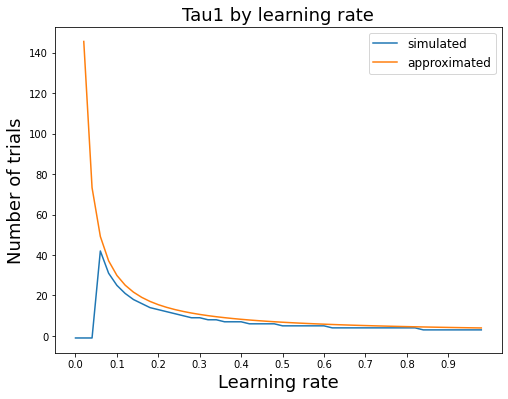

In [337]:
plot_tau1_real_and_approximate(tau1_by_lr_array,approx_tau1s)
plt.savefig("Tau1approx")

In [96]:
def equality_in_terms_of_beta(C, tau1, lr):
    return ((1-(1/(2*lr*tau1))) * np.log(1-(1/(2*lr*tau1))) - (1-(1/(2*lr*tau1)))*np.log(C[3]) - 0.5*np.log(C[2]/(2*C[1]*C[0])) )


In [20]:
len([1,2,3,4,5,6,7,8,9,10])

10

In [117]:
import numpy as np
taus_per_beta = np.zeros((10,99))
C = np.array([3,1,4,2])
for b, beta in enumerate(np.linspace(1,5,10)):
    for t, tau in enumerate(range(1,100)):
        C_ = pymdp.maths.softmax(beta*C)
        taus_per_beta[b,t] = equality_in_terms_of_beta(C_, tau, lr = 0.3)

    


<ipython-input-96-c9fb53c9e1cf>:2: RuntimeWarning: invalid value encountered in log
  return ((1-(1/(2*lr*tau1))) * np.log(1-(1/(2*lr*tau1))) - (1-(1/(2*lr*tau1)))*np.log(C[3]) - 0.5*np.log(C[2]/(2*C[1]*C[0])) )


In [52]:
np.linspace(0,30,50)

array([ 0.        ,  0.6122449 ,  1.2244898 ,  1.83673469,  2.44897959,
        3.06122449,  3.67346939,  4.28571429,  4.89795918,  5.51020408,
        6.12244898,  6.73469388,  7.34693878,  7.95918367,  8.57142857,
        9.18367347,  9.79591837, 10.40816327, 11.02040816, 11.63265306,
       12.24489796, 12.85714286, 13.46938776, 14.08163265, 14.69387755,
       15.30612245, 15.91836735, 16.53061224, 17.14285714, 17.75510204,
       18.36734694, 18.97959184, 19.59183673, 20.20408163, 20.81632653,
       21.42857143, 22.04081633, 22.65306122, 23.26530612, 23.87755102,
       24.48979592, 25.10204082, 25.71428571, 26.32653061, 26.93877551,
       27.55102041, 28.16326531, 28.7755102 , 29.3877551 , 30.        ])

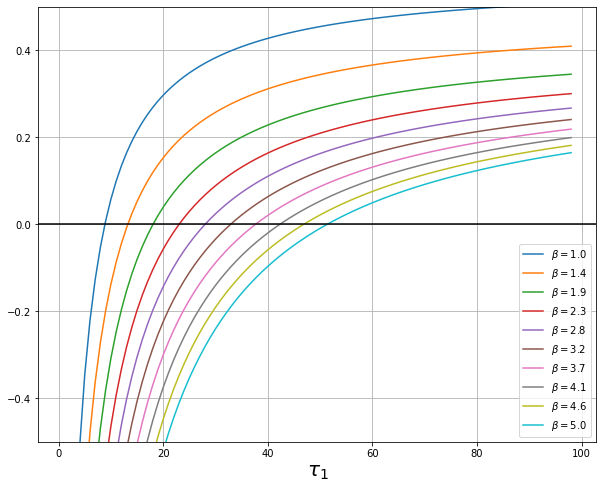

In [123]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,8))
for b, beta in enumerate(np.linspace(1,5,10)):
    plt.plot(taus_per_beta[b], label = r'$\beta =$' + str(beta.round(1)))
plt.ylim(-0.5,0.5)
plt.axhline(0, color = "black") #x-axis
plt.grid()
plt.xlabel(r'$\tau_1 $',fontsize = 20)
plt.legend()


In [93]:
pymdp.maths.softmax(np.array([3,1,4,2])).round(2)

array([0.24, 0.03, 0.64, 0.09])

In [94]:
0.24+0.03+0.64+0.09

1.0

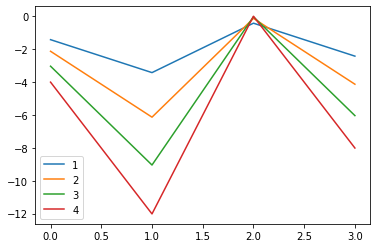

In [91]:
import pymdp 

plt.plot(np.log(pymdp.maths.softmax(np.array([3,1,4,2]))), label = 1)
plt.plot(np.log(pymdp.maths.softmax(np.array([3,1,4,2])*2)),label = 2)
plt.plot(np.log(pymdp.maths.softmax(np.array([3,1,4,2])*3)),label=3)
plt.plot(np.log(pymdp.maths.softmax(np.array([3,1,4,2])*4)),label=4)

plt.legend()


<Figure size 432x288 with 0 Axes>

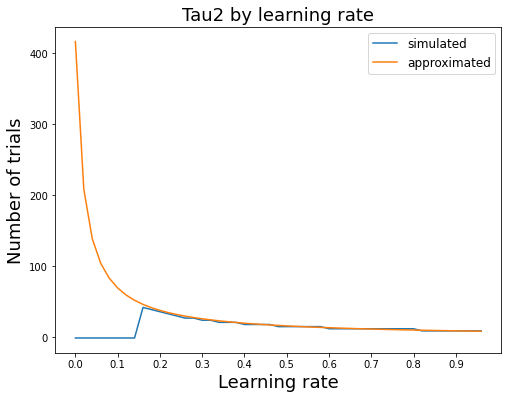

In [339]:
plot_tau2_real_and_approximate(tau2_by_lr_array[1:],approx_tau2s[1:])
plt.savefig("Tau2 approx")

Simulated parameters of the dirichlet prior over time

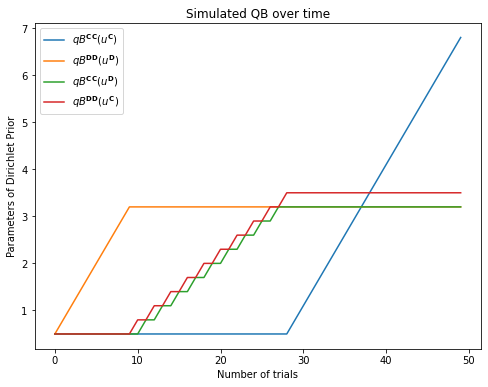

In [239]:
qBC_C, qBD_D, qBC_D, qBD_C = plot_dirichlet_parameters(qpB_over_time, T)

Analytically derived parameters of the dirichlet prior over time

Text(0.5, 1.0, 'Approximation of Dirichlet priors over time')

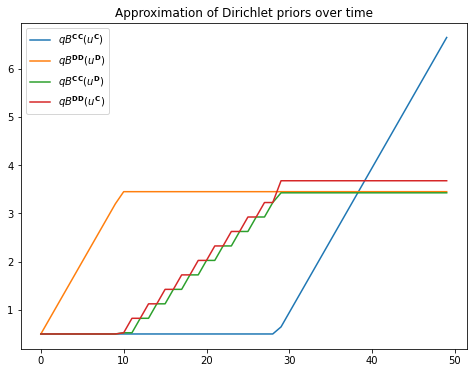

In [303]:
tau1 = derived_tau1(lr)
tau2 = derived_tau2(lr)
derived_qBC_over_time, derived_qBD_over_time, derived_BC_over_time, derived_BD_over_time = approximate_transitions_over_time(lr,T,tau1,tau2)

fig = plt.figure(figsize = (8,6))
plt.plot([q[0,0] for q in derived_qBC_over_time[:50]],label = r"$qB^{\mathbf{CC}}(u^{\mathbf{C}})$")
plt.plot([q[-1,-1] for q in derived_qBD_over_time[:50]], label = r"$qB^{\mathbf{DD}}(u^{\mathbf{D}})$")
plt.plot([q[3,0] for q in derived_qBD_over_time[:50]], label = r"$qB^{\mathbf{CC}}(u^{\mathbf{D}})$")
plt.plot([q[0,3] for q in derived_qBC_over_time[:50]],  label = r"$qB^{\mathbf{DD}}(u^{\mathbf{C}})$")
plt.legend()
plt.title("Approximation of Dirichlet priors over time")
# plt.plot(qBC_C, label = r"$qB^{\mathbf{CC}}(u^{\mathbf{C}})$")

# plt.plot(qBD_D, label = r"$qB^{\mathbf{DD}}(u^{\mathbf{D}})$")
# plt.plot(qBC_D, label = r"$qB^{\mathbf{CC}}(u^{\mathbf{D}})$")
# plt.plot(qBD_C, label = r"$qB^{\mathbf{DD}}(u^{\mathbf{C}})$")

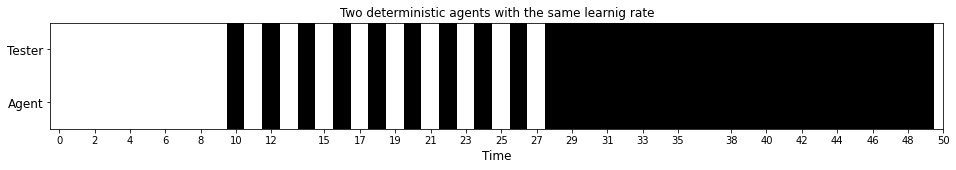

In [313]:
agent_pavlov, agent_2, D = construct(lr_pB = lr, lr_pB_2=lr, factors_to_learn="all")
#training
actions_over_time, B1_over_time, qpB_over_time, q_pi_over_time, q_s_over_time, agent = run_sim_collect_all_data(agent_pavlov, agent_2, observation_1 = [1], observation_2 = [1],D=D,T=T)
T = actions_over_time.shape[0]

fig, ax = plt.subplots(figsize = (16,15))
ax.grid(color='w', which = 'minor', linestyle='-', linewidth=2)
ax.set_xlabel("Time")
im = ax.imshow(actions_over_time.T,cmap ='gray', aspect = 3, vmin=0, vmax =1, interpolation="None")
ax.set_xlabel("Time",fontsize = 12)
ax.set_xticks(np.linspace(0,T,25).round(0),fontsize = 12)
ax.set_yticks([0, 1], labels=["Tester", "Agent"],fontsize = 12)
plt.title("Two deterministic agents with the same learnig rate")
plt.show()


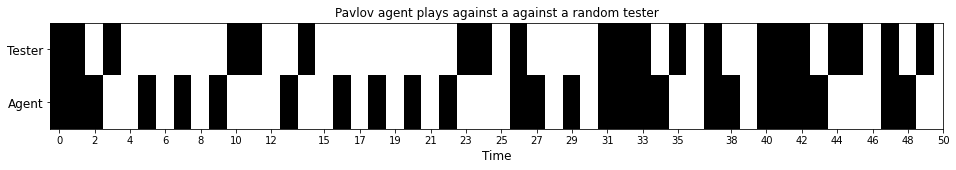

In [318]:
#testing
actions_over_time, agent = sweep_with_testing(agent_pavlov, agent_2, observation_1 = [0], T=50)
fig, ax = plt.subplots(figsize = (16,15))
ax.grid(color='w', which = 'minor', linestyle='-', linewidth=2)
ax.set_xlabel("Time")
im = ax.imshow(actions_over_time.T,cmap ='gray', aspect = 3, vmin=0, vmax =1, interpolation="None")
ax.set_xlabel("Time",fontsize = 12)
ax.set_xticks(np.linspace(0,T,25).round(0),fontsize = 12)
ax.set_yticks([0, 1], labels=["Tester", "Agent"],fontsize = 12)
plt.title("Pavlov agent plays against a against a random tester")
plt.show()
#cooperate = 0 -- black


[[0.13513514 0.38461538 0.5        0.13513514]
 [0.86486486 0.61538462 0.5        0.86486486]]


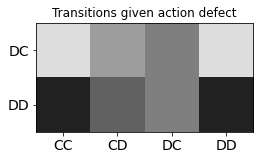

[[0.92857143 0.5        0.5        0.875     ]
 [0.07142857 0.5        0.5        0.125     ]]


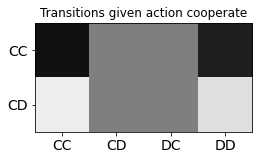

In [319]:
#strategy
plot_b_matrices(agent_pavlov)

Text(0.5, 1.0, 'Learned Pavlov Strategy')

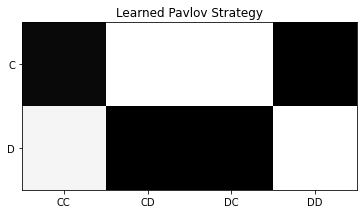

In [320]:
action_CC, qs, qp_CC = single_agent_run(observation_CC,agent_pavlov)
action_CD, qs, qp_CD = single_agent_run(observation_CD,agent_pavlov)
action_DC, qs, qp_DC = single_agent_run(observation_DC,agent_pavlov)
action_DD, qs, qp_DD = single_agent_run(observation_DD,agent_pavlov)
qpis = np.array([qp_CC,qp_CD,qp_DC,qp_DD])
plt.imshow(qpis.T,cmap=cmap0)
plt.yticks(range(2), labels = ['C','D'])
plt.xticks(range(4), labels = ['CC','CD', 'DC','DD'])
plt.title("Learned Pavlov Strategy")


Gonna make matrices for specific strategies and compete against the matrices that emerge from stochasitc

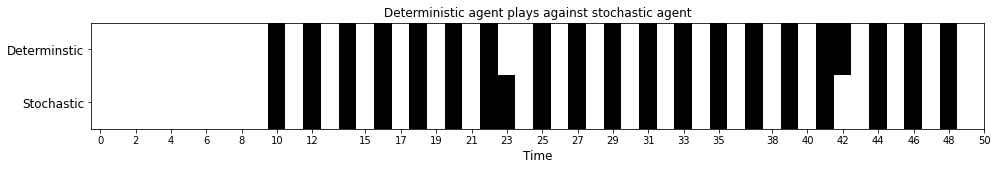

In [329]:
#train vs stochastic agent
agent_deterministic, agent_stochastic, D = construct(lr_pB = 0.3,lr_pB_2 = 0.3, factors_to_learn="all")
#agent_1.action_selection = "stochastic"
agent_stochastic.action_selection = "stochastic"
#agent_1.alpha = 5.0
agent_stochastic.alpha = 4.0
actions_over_time, B1_over_time, qpB_over_time, q_pi_over_time, q_s_over_time, agent = run_sim_collect_all_data(agent_deterministic, agent_stochastic, observation_1 = [0], observation_2 = [0],D=D,T=50)

fig, ax = plt.subplots(figsize = (16,15))
ax.grid(color='w', which = 'minor', linestyle='-', linewidth=2)
ax.set_xlabel("Time")
im = ax.imshow(actions_over_time.T,cmap ='gray', aspect = 3, vmin=0, vmax =1, interpolation="None")
ax.set_xlabel("Time",fontsize = 12)
ax.set_xticks(np.linspace(0,T,25).round(0),fontsize = 12)
ax.set_yticks([0, 1], labels=["Determinstic", "Stochastic"],fontsize = 12)
plt.title("Deterministic agent plays against stochastic agent")
plt.show()
#plot_sim(actions_over_time, aspect = 5)



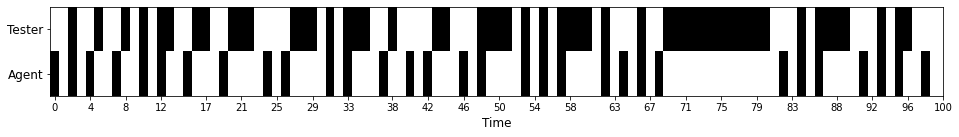

In [330]:
#testing
agent_deterministic.lr_pB = 0
actions_over_time, agent = sweep_with_testing(agent_deterministic, agent_stochastic, observation_1 = [0], T=100)
plot_testing(actions_over_time, aspect = 5)


[[0.38461538 0.22727273 0.11428571 0.02226027]
 [0.61538462 0.77272727 0.88571429 0.97773973]]


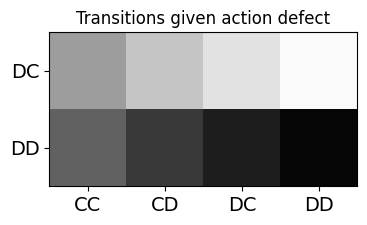

[[0.5        0.5        0.38461538 0.26315789]
 [0.5        0.5        0.61538462 0.73684211]]


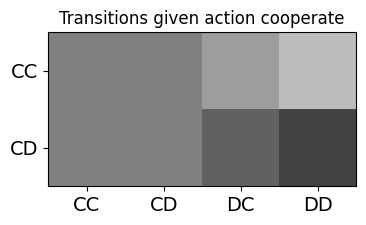

In [ ]:
#strategy
plot_b_matrices(agent_deterministic)

([<matplotlib.axis.XTick at 0x13150aa30>,
 [Text(0, 0, 'CC'), Text(1, 0, 'CD'), Text(2, 0, 'DC'), Text(3, 0, 'DD')])

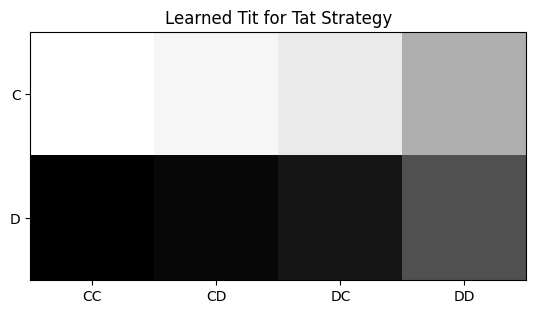

In [ ]:
action_CC, qs, qp_CC = single_agent_run(observation_CC,agent)
action_CD, qs, qp_CD = single_agent_run(observation_CD,agent)
action_DC, qs, qp_DC = single_agent_run(observation_DC,agent)
action_DD, qs, qp_DD = single_agent_run(observation_DD,agent)
qpis = np.array([qp_CC,qp_CD,qp_DC,qp_DD])
plt.title("Learned Tit for Tat Strategy")
plt.imshow(qpis.T,cmap=cmap0)
plt.yticks(range(2), labels = ['C','D'])
plt.xticks(range(4), labels = ['CC','CD', 'DC','DD'])


defect if CD or DD, cooperate if CC or DC (this is tit for tat!)

In [ ]:
agent_tit_for_tat.lr_pB

0

In [ ]:
agent_pavlov.lr_pB = 

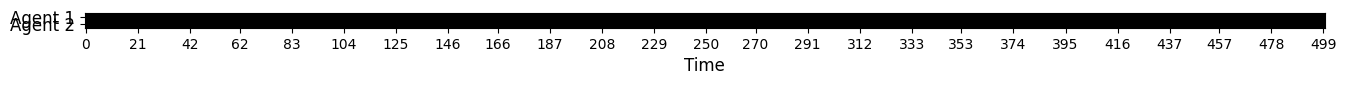

In [ ]:

actions_over_time, B1_over_time, q_pi_over_time, qs_over_time, agent = run_sim_collect_all_data(agent_pavlov, agent, observation_1 = [0], observation_2 = [0],D=D,T=500)
plot_sim(actions_over_time, aspect = 3)
